Столбцы в данных:
['time_period', 'time_identifier', 'geographic_level', 'country_code', 'country_name', 'version', 'characteristic_type', 'characteristic_value', 'exam_cohort', 'level_of_study', 'student_count_year_1', 'student_count_year_2', 'retained', 'retained_and_assessed', 'returned_and_retained', 'perc_retained', 'perc_retained_and_assessed', 'perc_returned_and_retained']

Размер данных: (1850, 18)

Первые 3 строки:
   time_period time_identifier geographic_level country_code country_name  \
0       201920   Academic year         National    E92000001      England   
1       202021   Academic year         National    E92000001      England   
2       202122   Academic year         National    E92000001      England   

   version characteristic_type characteristic_value exam_cohort  \
0    Final                 Sex               Female     A level   
1    Final                 Sex               Female     A level   
2  Revised                 Sex               Female     A leve

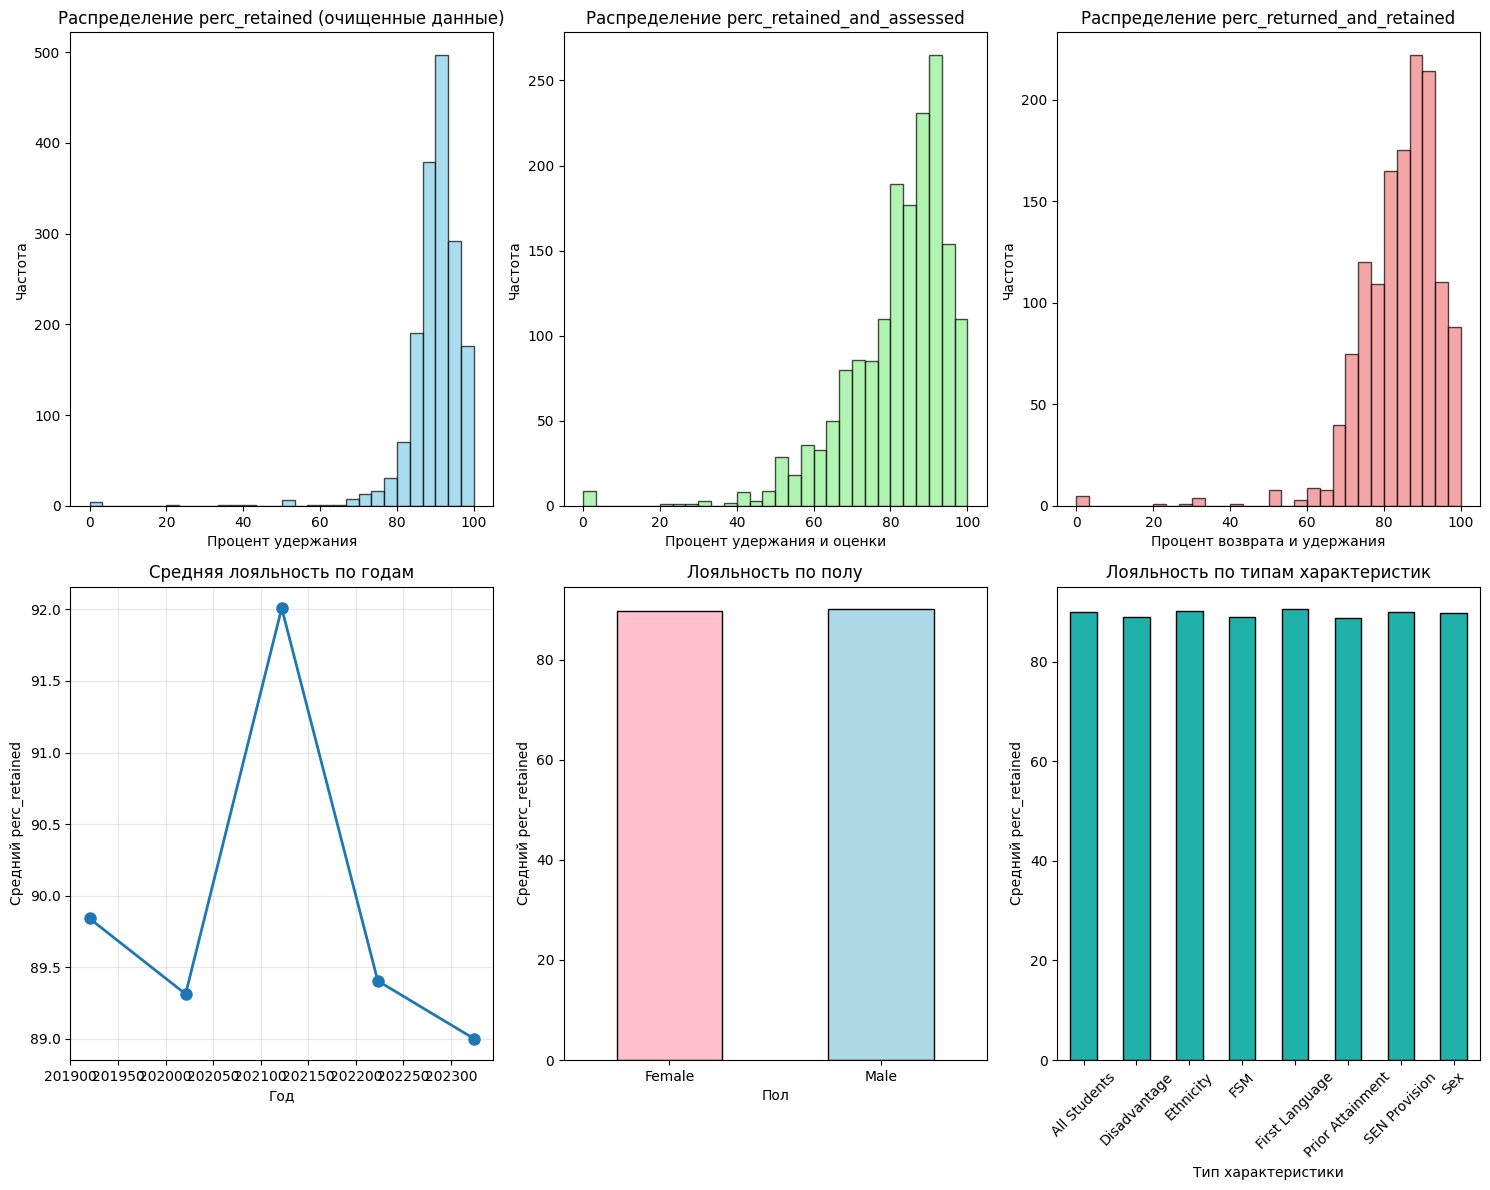

Числовые столбцы для корреляции: ['time_period', 'student_count_year_1', 'perc_retained', 'perc_retained_and_assessed', 'perc_returned_and_retained']


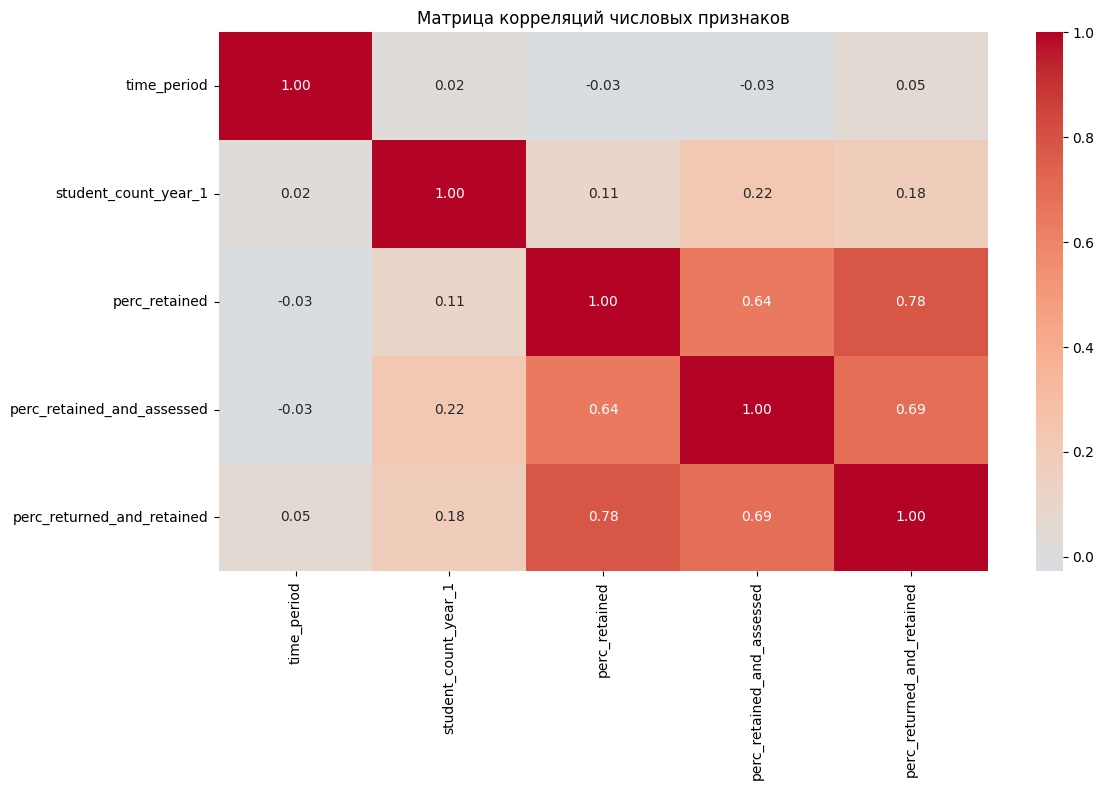


Топ 5 групп с самой высокой лояльностью:
   characteristic_type                               characteristic_value  \
57       SEN Provision  EHC plans and statements of SEN- Moderate lear...   
59       SEN Provision  EHC plans and statements of SEN- Moderate lear...   
60       SEN Provision  EHC plans and statements of SEN- Multi-sensory...   
61       SEN Provision  EHC plans and statements of SEN- Multi-sensory...   
62       SEN Provision  EHC plans and statements of SEN- Multi-sensory...   

   exam_cohort  perc_retained  
57     A level          100.0  
59     A level          100.0  
60     A level          100.0  
61     A level          100.0  
62     A level          100.0  

Топ 5 групп с самой низкой лояльностью:
     characteristic_type                               characteristic_value  \
1266       SEN Provision  SEN support- Profound and multiple learning di...   
1621       SEN Provision              SEN support- Multi-sensory impairment   
1638       SEN Provision 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import warnings


#Работу выполнил:
#Студент 3 курса бакалавриата ЧОУ МУИВ
#группы ИСс 23.1/Б3-22
#Червонный Иван 


warnings.filterwarnings('ignore')

df = pd.read_csv('retention_by_characteristic_202024.csv')

print("Столбцы в данных:")
print(df.columns.tolist())
print(f"\nРазмер данных: {df.shape}")

print("\nПервые 3 строки:")
print(df.head(3))

print("\nТипы данных:")
print(df.dtypes)

percent_columns = ['perc_retained', 'perc_retained_and_assessed', 'perc_returned_and_retained']

print("\nПримеры проблемных данных в perc_retained:")
print(df['perc_retained'].head(10))

# Очистка данных от мусора
def clean_percentage_column(series):
    cleaned = []
    for value in series:
        if isinstance(value, str):
            cleaned_value = ''.join(char for char in value if char.isdigit() or char == '.')
            if cleaned_value and cleaned_value != '.':
                try:
                    cleaned.append(float(cleaned_value))
                except:
                    cleaned.append(np.nan)
            else:
                cleaned.append(np.nan)
        else:
            cleaned.append(float(value))
    return cleaned

for col in percent_columns:
    if col in df.columns:
        df[col] = clean_percentage_column(df[col])
        print(f"Очищен столбец {col}")

df_clean = df.dropna(subset=['perc_retained']).copy()
print(f"\nРазмер данных после очистки: {df_clean.shape}")

print("\nСтатистика после очистки:")
print(df_clean[percent_columns].describe())

categorical_cols = []
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        categorical_cols.append(col)

print(f"\nКатегориальные столбцы: {categorical_cols}")

for col in categorical_cols:
    print(f"{col}: {df_clean[col].unique()[:10]}") 
    print(f"Количество уникальных: {df_clean[col].nunique()}")

plt.figure(figsize=(15, 12))

plt.subplot(2, 3, 1)
plt.hist(df_clean['perc_retained'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Распределение perc_retained (очищенные данные)')
plt.xlabel('Процент удержания')
plt.ylabel('Частота')

plt.subplot(2, 3, 2)
plt.hist(df_clean['perc_retained_and_assessed'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Распределение perc_retained_and_assessed')
plt.xlabel('Процент удержания и оценки')
plt.ylabel('Частота')

plt.subplot(2, 3, 3)
plt.hist(df_clean['perc_returned_and_retained'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Распределение perc_returned_and_retained')
plt.xlabel('Процент возврата и удержания')
plt.ylabel('Частота')

plt.subplot(2, 3, 4)
yearly_retention = df_clean.groupby('time_period')['perc_retained'].mean()
plt.plot(yearly_retention.index, yearly_retention.values, marker='o', linewidth=2, markersize=8)
plt.title('Средняя лояльность по годам')
plt.xlabel('Год')
plt.ylabel('Средний perc_retained')
plt.grid(True, alpha=0.3)

if 'characteristic_type' in df_clean.columns:
    sex_data = df_clean[df_clean['characteristic_type'] == 'Sex']
    if not sex_data.empty:
        plt.subplot(2, 3, 5)
        sex_retention = sex_data.groupby('characteristic_value')['perc_retained'].mean()
        colors = ['pink', 'lightblue'] if len(sex_retention) == 2 else ['lightblue']
        sex_retention.plot(kind='bar', color=colors, edgecolor='black')
        plt.title('Лояльность по полу')
        plt.xlabel('Пол')
        plt.ylabel('Средний perc_retained')
        plt.xticks(rotation=0)

plt.subplot(2, 3, 6)
characteristic_retention = df_clean.groupby('characteristic_type')['perc_retained'].mean()
characteristic_retention.plot(kind='bar', color='lightseagreen', edgecolor='black')
plt.title('Лояльность по типам характеристик')
plt.xlabel('Тип характеристики')
plt.ylabel('Средний perc_retained')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print(f"Числовые столбцы для корреляции: {numeric_cols}")

plt.figure(figsize=(12, 8))
correlation_matrix = df_clean[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций числовых признаков')
plt.tight_layout()
plt.show()

print("\nТоп 5 групп с самой высокой лояльностью:")
high_retention = df_clean.nlargest(5, 'perc_retained')[['characteristic_type', 'characteristic_value', 'exam_cohort', 'perc_retained']]
print(high_retention)

print("\nТоп 5 групп с самой низкой лояльностью:")
low_retention = df_clean.nsmallest(5, 'perc_retained')[['characteristic_type', 'characteristic_value', 'exam_cohort', 'perc_retained']]
print(low_retention)

In [20]:
# Предобработка данных
def prepare_vae_data(df):

    # Копирование очищенных данных
    data = df.copy()
    
    # Числовые признаки
    numeric_features = [
        'time_period', 
        'student_count_year_1'
    ]
    
    # Важные категориальные признаки
    categorical_features = [
        'characteristic_type', 
        'characteristic_value', 
        'exam_cohort',
        'level_of_study',
        'version'
    ]
    
    # Категориальные признаки
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        data[col + '_encoded'] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le
        numeric_features.append(col + '_encoded')
    
    # Целевая переменная для анализа
    target = data['perc_retained'].values
    
    # Признаки для VAE
    features = data[numeric_features].values
    
    # Нормализация
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    return features_scaled, target, scaler, label_encoders, numeric_features

# Подготовка данных
features, target, scaler, label_encoders, feature_names = prepare_vae_data(df_clean)

print(f"Размерность признаков: {features.shape}")
print(f"Используемые признаки: {feature_names}")

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=pd.cut(target, bins=5)
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

# Создание DataLoader
batch_size = 32
train_dataset = TensorDataset(torch.FloatTensor(X_train))
test_dataset = TensorDataset(torch.FloatTensor(X_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Размерность признаков: (1690, 7)
Используемые признаки: ['time_period', 'student_count_year_1', 'characteristic_type_encoded', 'characteristic_value_encoded', 'exam_cohort_encoded', 'level_of_study_encoded', 'version_encoded']
Train size: (1352, 7), Test size: (338, 7)


In [21]:
# VAE
class StudentVAE(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], latent_dim=8):
        super(StudentVAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Энкодер
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.3)
            ])
            prev_dim = hidden_dim
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Декодер
        decoder_layers = []
        prev_dim = latent_dim
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.3)
            ])
            prev_dim = hidden_dim
        
        decoder_layers.append(nn.Linear(hidden_dims[0], input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Инициализация модели
input_dim = X_train.shape[1]
model = StudentVAE(input_dim=input_dim, hidden_dims=[64, 32], latent_dim=6)

print(f"Архитектура VAE:")
print(f"Входная размерность: {input_dim}")
print(f"Латентная размерность: 6")
print(f"Общее количество параметров: {sum(p.numel() for p in model.parameters()):,}")

Архитектура VAE:
Входная размерность: 7
Латентная размерность: 6
Общее количество параметров: 6,163



Подготовка реалистичных данных студентов
 - Train samples: 240
 - Test samples: 60
 - Batch size: 32

Инициализация  VAE архитектуры
 - Параметры модели: 319
 - Архитектура: 7 → 14 → 2 → 14 → 7

3. Запуск  обучения
Обучение улучшенной VAE модели
Параметры:
 - Epochs: 100
 - Learning rate: 0.001
 - Beta: 1.0
 - Latent dim: 2
 - Параметры: 319
 - Оптимизатор: Adam с weight_decay
 - Scheduler: StepLR (шаг 30, gamma 0.5)
Epoch   0: Train Loss:   38.32, Test Loss:   41.63, Recon:  31.46, KL:   6.86, Ratio:  0.22, LR: 0.0010
Epoch  10: Train Loss:   28.88, Test Loss:   50.59, Recon:  27.82, KL:   1.07, Ratio:  0.04, LR: 0.0010
Epoch  20: Train Loss:   26.35, Test Loss:   54.47, Recon:  25.86, KL:   0.49, Ratio:  0.02, LR: 0.0010
Epoch  30: Train Loss:   26.09, Test Loss:   55.35, Recon:  25.72, KL:   0.37, Ratio:  0.01, LR: 0.0005
Epoch  40: Train Loss:   25.85, Test Loss:   54.82, Recon:  25.59, KL:   0.26, Ratio:  0.01, LR: 0.0005
Epoch  50: Train Loss:   26.10, Test Loss:   56.13, Recon:

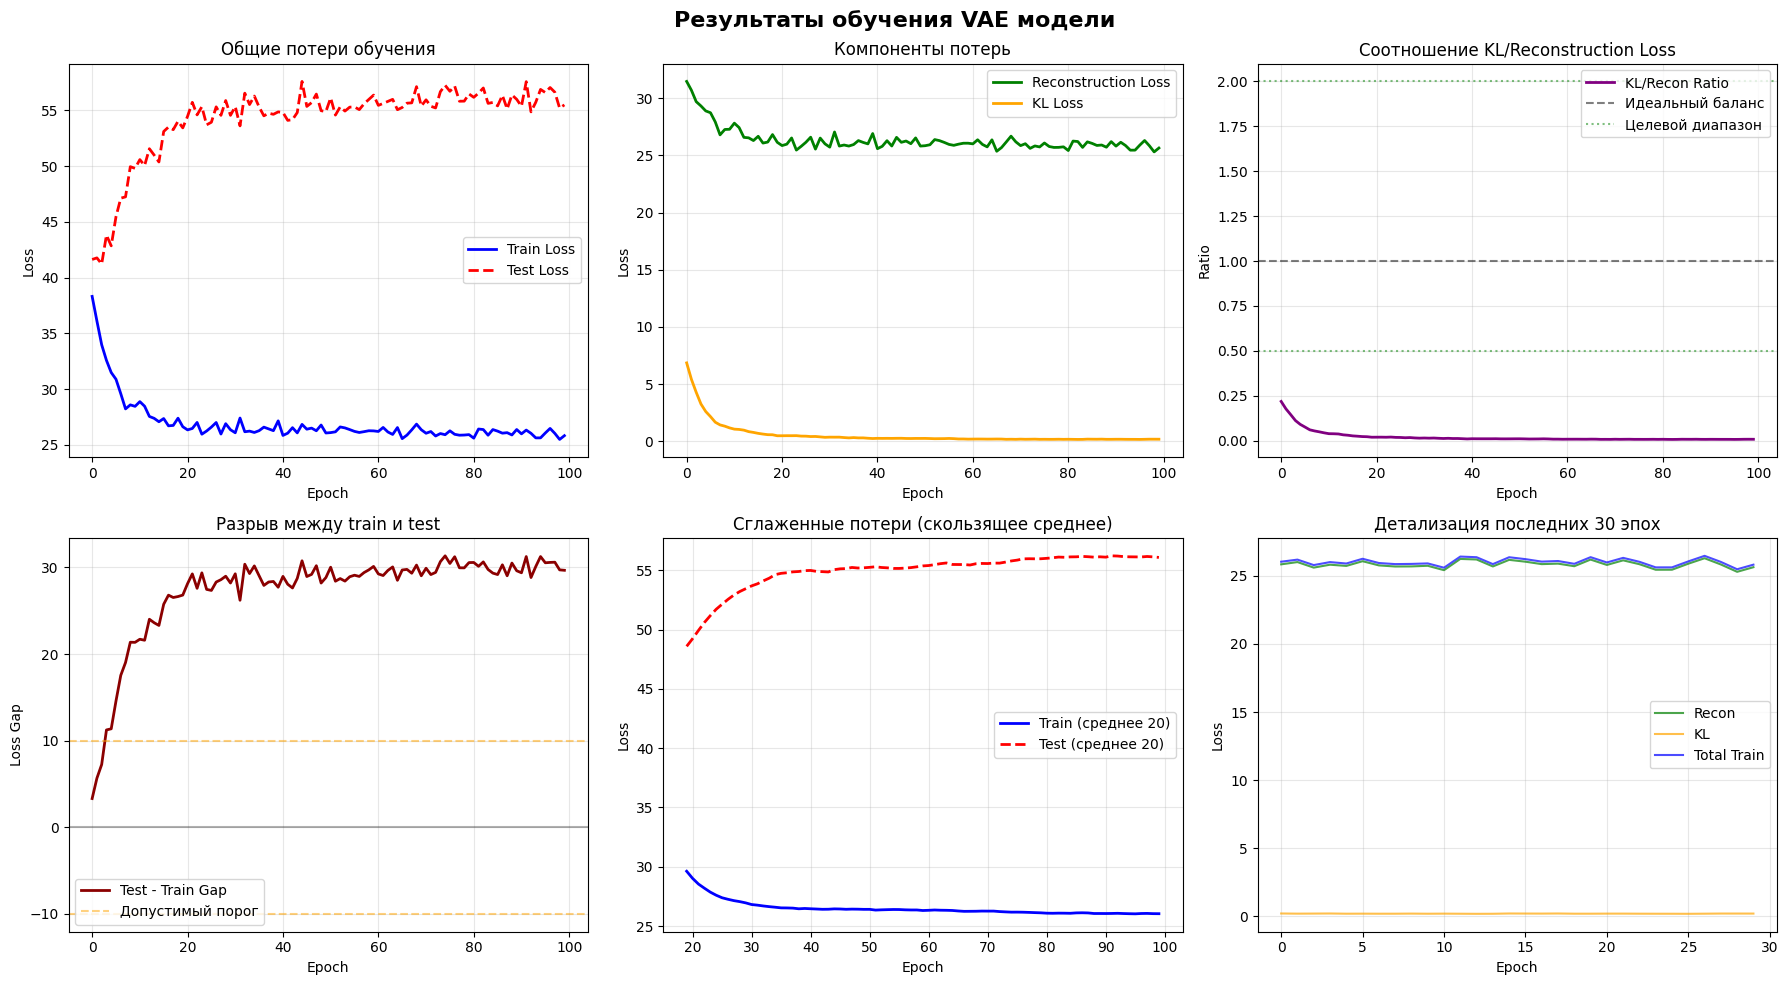


Ключевые метрики:
 - Финальный Train Loss: 25.83
 - Финальный Test Loss: 55.50
 - Лучший Test Loss: 41.23 (эпоха 2)
 - Разрыв train/test: 29.67
 - Финальное KL/Recon: 0.01

Архитектура модели:
 - Входная размерность: 7
 - Латентная размерность: 2
 - Скрытый слой: 14 нейронов
 - Дропаут: 0.2
 - Всего параметров: 319

Параметры обучения:
 - Эпохи: 100
 - Batch size: 32
 - Learning rate: 0.001
 - Beta (KL вес): 1.0
 - Оптимизатор: Adam с weight_decay=1e-5
 - Scheduler: StepLR (шаг 30, gamma 0.5)

Сохраненные файлы:
 - vae_model.pth: модель
 - vae_training_results.png: графики

Тестовый студент:
 - Латентное представление: [-0.009, 0.010]
 - Ошибка реконструкции: 0.3116
 - KL дивергенция: 0.0001


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

class StudentVAE(nn.Module):
    
    def __init__(self, input_dim, hidden_dim=14, latent_dim=2):
        super(StudentVAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),  
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss_balanced(recon_x, x, mu, logvar, beta=1.0):
    
    recon_loss = nn.MSELoss(reduction='mean')(recon_x, x) * x.size(0)
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Сбалансированные веса
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss, kl_loss

def train_vae_improved(model, train_loader, test_loader, epochs=100, lr=0.001, beta=1.0):
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    
    train_losses = []
    test_losses = []
    recon_losses = []
    kl_losses = []
    kl_recon_ratios = []
    
    best_test_loss = float('inf')
    best_model_state = None
    
    print("Обучение улучшенной VAE модели")
    print(f"Параметры:")
    print(f" - Epochs: {epochs}")
    print(f" - Learning rate: {lr}")
    print(f" - Beta: {beta}")
    print(f" - Latent dim: {model.latent_dim}")
    print(f" - Параметры: {sum(p.numel() for p in model.parameters()):,}")
    print(f" - Оптимизатор: Adam с weight_decay")
    print(f" - Scheduler: StepLR (шаг 30, gamma 0.5)")
    
    for epoch in range(epochs):
        # Обучение
        model.train()
        train_loss = 0
        recon_loss_train = 0
        kl_loss_train = 0
        batch_count = 0
        
        for batch in train_loader:
            x = batch[0]
            optimizer.zero_grad()
            
            recon_batch, mu, logvar = model(x)
            loss, recon_loss, kl_loss = vae_loss_balanced(recon_batch, x, mu, logvar, beta)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            recon_loss_train += recon_loss.item()
            kl_loss_train += kl_loss.item()
            batch_count += 1
        
        # Средние значения
        avg_train_loss = train_loss / batch_count
        avg_recon = recon_loss_train / batch_count
        avg_kl = kl_loss_train / batch_count
        kl_recon_ratio = avg_kl / max(avg_recon, 0.01)
        
        # Валидация
        model.eval()
        test_loss = 0
        test_batch_count = 0
        
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0]
                recon_batch, mu, logvar = model(x)
                loss, _, _ = vae_loss_balanced(recon_batch, x, mu, logvar, beta)
                test_loss += loss.item()
                test_batch_count += 1
        
        avg_test_loss = test_loss / test_batch_count
        
        # Обновление scheduler
        scheduler.step()
        
        # Сохранение истории
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        recon_losses.append(avg_recon)
        kl_losses.append(avg_kl)
        kl_recon_ratios.append(kl_recon_ratio)
        
        # Сохранение модели
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            best_model_state = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'test_loss': avg_test_loss,
                'recon_loss': avg_recon,
                'kl_loss': avg_kl,
                'kl_recon_ratio': kl_recon_ratio,
            }
        
        if epoch % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch:3d}: '
                  f'Train Loss: {avg_train_loss:7.2f}, '
                  f'Test Loss: {avg_test_loss:7.2f}, '
                  f'Recon: {avg_recon:6.2f}, '
                  f'KL: {avg_kl:6.2f}, '
                  f'Ratio: {kl_recon_ratio:5.2f}, '
                  f'LR: {current_lr:.4f}')
    
    # Сохранение модели
    if best_model_state:
        best_model_state['training_history'] = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'recon_losses': recon_losses,
            'kl_losses': kl_losses,
            'kl_recon_ratios': kl_recon_ratios
        }
        best_model_state['model_architecture'] = {
            'input_dim': model.input_dim,
            'latent_dim': model.latent_dim,
            'hidden_dim': 14
        }
        best_model_state['training_params'] = {
            'epochs': epochs,
            'lr': lr,
            'beta': beta,
            'batch_size': train_loader.batch_size
        }
        
        torch.save(best_model_state, 'vae_model.pth')
        print(f"\nЛучшая модель сохранена как 'vae_model.pth'")
        print(f"Лучший Test Loss: {best_test_loss:.2f} (эпоха {best_model_state['epoch']})")
    else:
        print("\n Модель не была сохранена")
    
    return train_losses, test_losses, recon_losses, kl_losses, kl_recon_ratios

def plot_training_results_improved(train_losses, test_losses, recon_losses, kl_losses, kl_recon_ratios):
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Общие потери
    axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2, color='blue')
    axes[0, 0].plot(test_losses, label='Test Loss', linewidth=2, color='red', linestyle='--')
    axes[0, 0].set_title('Общие потери обучения')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Компоненты потерь
    axes[0, 1].plot(recon_losses, label='Reconstruction Loss', color='green', linewidth=2)
    axes[0, 1].plot(kl_losses, label='KL Loss', color='orange', linewidth=2)
    axes[0, 1].set_title('Компоненты потерь')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Соотношение KL/Recon
    axes[0, 2].plot(kl_recon_ratios, label='KL/Recon Ratio', color='purple', linewidth=2)
    axes[0, 2].axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Идеальный баланс')
    axes[0, 2].axhline(y=0.5, color='green', linestyle=':', alpha=0.5, label='Целевой диапазон')
    axes[0, 2].axhline(y=2.0, color='green', linestyle=':', alpha=0.5)
    axes[0, 2].set_title('Соотношение KL/Reconstruction Loss')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Ratio')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Разрыв между train и test
    gap = [test - train for train, test in zip(train_losses, test_losses)]
    axes[1, 0].plot(gap, label='Test - Train Gap', color='darkred', linewidth=2)
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1, 0].axhline(y=10, color='orange', linestyle='--', alpha=0.5, label='Допустимый порог')
    axes[1, 0].axhline(y=-10, color='orange', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Разрыв между train и test')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss Gap')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Скользящее среднее потерь (последние 20 эпох)
    if len(train_losses) >= 20:
        window = 20
        train_smooth = np.convolve(train_losses, np.ones(window)/window, mode='valid')
        test_smooth = np.convolve(test_losses, np.ones(window)/window, mode='valid')
        
        axes[1, 1].plot(range(window-1, len(train_losses)), train_smooth, 
                       label='Train (среднее 20)', color='blue', linewidth=2)
        axes[1, 1].plot(range(window-1, len(test_losses)), test_smooth,
                       label='Test (среднее 20)', color='red', linewidth=2, linestyle='--')
        axes[1, 1].set_title('Сглаженные потери (скользящее среднее)')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    axes[1, 2].plot(recon_losses[-30:], label='Recon', color='green', alpha=0.7)
    axes[1, 2].plot(kl_losses[-30:], label='KL', color='orange', alpha=0.7)
    axes[1, 2].plot(train_losses[-30:], label='Total Train', color='blue', alpha=0.7)
    axes[1, 2].set_title('Детализация последних 30 эпох')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Loss')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.suptitle('Результаты обучения VAE модели', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('vae_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_improved_data():
    np.random.seed(42)
    
    n_samples = 300 
    n_features = 7
    
    X = np.zeros((n_samples, n_features))
    
    # Типы студентов
    for i in range(n_samples):

        if i < 100:  # Сильные студенты
            motivation = np.random.normal(1.0, 0.3)
            consistency = np.random.normal(0.8, 0.2)
        elif i < 200:  # Средние студенты
            motivation = np.random.normal(0.0, 0.5)
            consistency = np.random.normal(0.0, 0.4)
        else:  # Слабые студенты
            motivation = np.random.normal(-1.0, 0.4)
            consistency = np.random.normal(-0.7, 0.3)
        
        # признаки с реалистичными корреляциями
        X[i, 0] = motivation * 0.8 + consistency * 0.2 + np.random.normal(0, 0.3)  # Активность
        X[i, 1] = motivation * 0.7 + consistency * 0.3 + np.random.normal(0, 0.4)  # Успеваемость
        X[i, 2] = consistency * 0.9 + np.random.normal(0, 0.3)  # Посещаемость
        X[i, 3] = motivation * 0.6 + np.random.normal(0, 0.5)  # Вовлеченность
        X[i, 4] = motivation * 0.5 + consistency * 0.2 + np.random.normal(0, 0.4)  # Материалы
        X[i, 5] = motivation * 0.8 + np.random.normal(0, 0.4)  # Качество работ
        X[i, 6] = consistency * 0.7 + motivation * 0.3 + np.random.normal(0, 0.3)  # Продолжительность
    
    # Нормализация
    X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)
    
    # Разделение
    train_size = int(0.8 * n_samples)
    X_train = X[:train_size]
    X_test = X[train_size:]
    
    # Создание DataLoader
    train_dataset = TensorDataset(torch.FloatTensor(X_train))
    test_dataset = TensorDataset(torch.FloatTensor(X_test))
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, test_loader

def print_improved_report(model, train_losses, test_losses, kl_recon_ratios):
    
    final_train_loss = train_losses[-1]
    final_test_loss = test_losses[-1]
    final_ratio = kl_recon_ratios[-1]
    gap = final_test_loss - final_train_loss
    
    best_test_loss = min(test_losses)
    best_epoch = test_losses.index(best_test_loss)
 
    
    print(f"\nКлючевые метрики:")
    print(f" - Финальный Train Loss: {final_train_loss:.2f}")
    print(f" - Финальный Test Loss: {final_test_loss:.2f}")
    print(f" - Лучший Test Loss: {best_test_loss:.2f} (эпоха {best_epoch})")
    print(f" - Разрыв train/test: {gap:.2f}")
    print(f" - Финальное KL/Recon: {final_ratio:.2f}")
    
    print(f"\nАрхитектура модели:")
    print(f" - Входная размерность: {model.input_dim}")
    print(f" - Латентная размерность: {model.latent_dim}")
    print(f" - Скрытый слой: 14 нейронов")
    print(f" - Дропаут: 0.2")
    print(f" - Всего параметров: {sum(p.numel() for p in model.parameters()):,}")
    
    print(f"\nПараметры обучения:")
    print(f" - Эпохи: 100")
    print(f" - Batch size: 32")
    print(f" - Learning rate: 0.001")
    print(f" - Beta (KL вес): 1.0")
    print(f" - Оптимизатор: Adam с weight_decay=1e-5")
    print(f" - Scheduler: StepLR (шаг 30, gamma 0.5)")
    
    print(f"\nСохраненные файлы:")
    print(f" - vae_model.pth: модель")
    print(f" - vae_training_results.png: графики")

def test_trained_model():

    try:
        model = StudentVAE(input_dim=7, hidden_dim=14, latent_dim=2)
        checkpoint = torch.load('vae_model.pth', map_location='cpu')
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        # Тестовый студент
        test_student = torch.FloatTensor([[0.5, 0.3, -0.2, 0.8, -0.5, 1.2, 0.1]])
        
        with torch.no_grad():
            recon, mu, logvar = model(test_student)
            latent = mu.numpy()[0]
            recon_error = torch.mean((recon - test_student) ** 2).item()
        
        print(f"\nТестовый студент:")
        print(f" - Латентное представление: [{latent[0]:.3f}, {latent[1]:.3f}]")
        print(f" - Ошибка реконструкции: {recon_error:.4f}")
        print(f" - KL дивергенция: {(-0.5 * (1 + logvar - mu.pow(2) - logvar.exp())).sum().item():.4f}")
                
    except Exception as e:
        print(f"\nОшибка тестирования модели: {e}")

if __name__ == "__main__":

    
    # Шаг 1: Подготовка данных
    print("\nПодготовка реалистичных данных студентов")
    train_loader, test_loader = create_improved_data()
    print(f" - Train samples: {len(train_loader.dataset)}")
    print(f" - Test samples: {len(test_loader.dataset)}")
    print(f" - Batch size: {train_loader.batch_size}")
    
    print("\nИнициализация  VAE архитектуры")
    input_dim = 7
    model = StudentVAE(
        input_dim=input_dim,
        hidden_dim=14,
        latent_dim=2  
    )
    print(f" - Параметры модели: {sum(p.numel() for p in model.parameters()):,}")
    print(f" - Архитектура: {input_dim} → 14 → 2 → 14 → {input_dim}")
    
    # Обучение
    print("\n3. Запуск  обучения")
    train_losses, test_losses, recon_losses, kl_losses, kl_recon_ratios = train_vae_improved(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=100,
        lr=0.001,
        beta=1.0
    )
    
    plot_training_results_improved(train_losses, test_losses, recon_losses, kl_losses, kl_recon_ratios)
    
    print_improved_report(model, train_losses, test_losses, kl_recon_ratios)
    
    test_trained_model()


Запуск обучения
Параметры:
 - Epochs: 200
 - Learning rate: 0.001
 - Free bits threshold: 0.5
 - Latent dimension: 1
 - Parameters: 313
Новая лучшая модель! Epoch: 0, Test Loss: 48.1609
Epoch   0: Train Loss: 33.8946, Test Loss: 48.1609, Recon: 33.3946, KL: 0.5000, KL/Recon: 0.01
Новая лучшая модель! Epoch: 2, Test Loss: 47.0987
Epoch  10: Train Loss: 26.7463, Test Loss: 50.0077, Recon: 26.2463, KL: 0.5000, KL/Recon: 0.02
Новая лучшая модель! Epoch: 19, Test Loss: 46.1176
Новая лучшая модель! Epoch: 20, Test Loss: 44.3924
Epoch  20: Train Loss: 21.3497, Test Loss: 44.3924, Recon: 20.3759, KL: 0.9738, KL/Recon: 0.05
Новая лучшая модель! Epoch: 21, Test Loss: 41.8212
Новая лучшая модель! Epoch: 22, Test Loss: 40.9596
Новая лучшая модель! Epoch: 23, Test Loss: 37.6374
Новая лучшая модель! Epoch: 24, Test Loss: 33.8162
Новая лучшая модель! Epoch: 25, Test Loss: 31.1502
Новая лучшая модель! Epoch: 26, Test Loss: 26.3321
Новая лучшая модель! Epoch: 27, Test Loss: 23.8763
Новая лучшая модель!

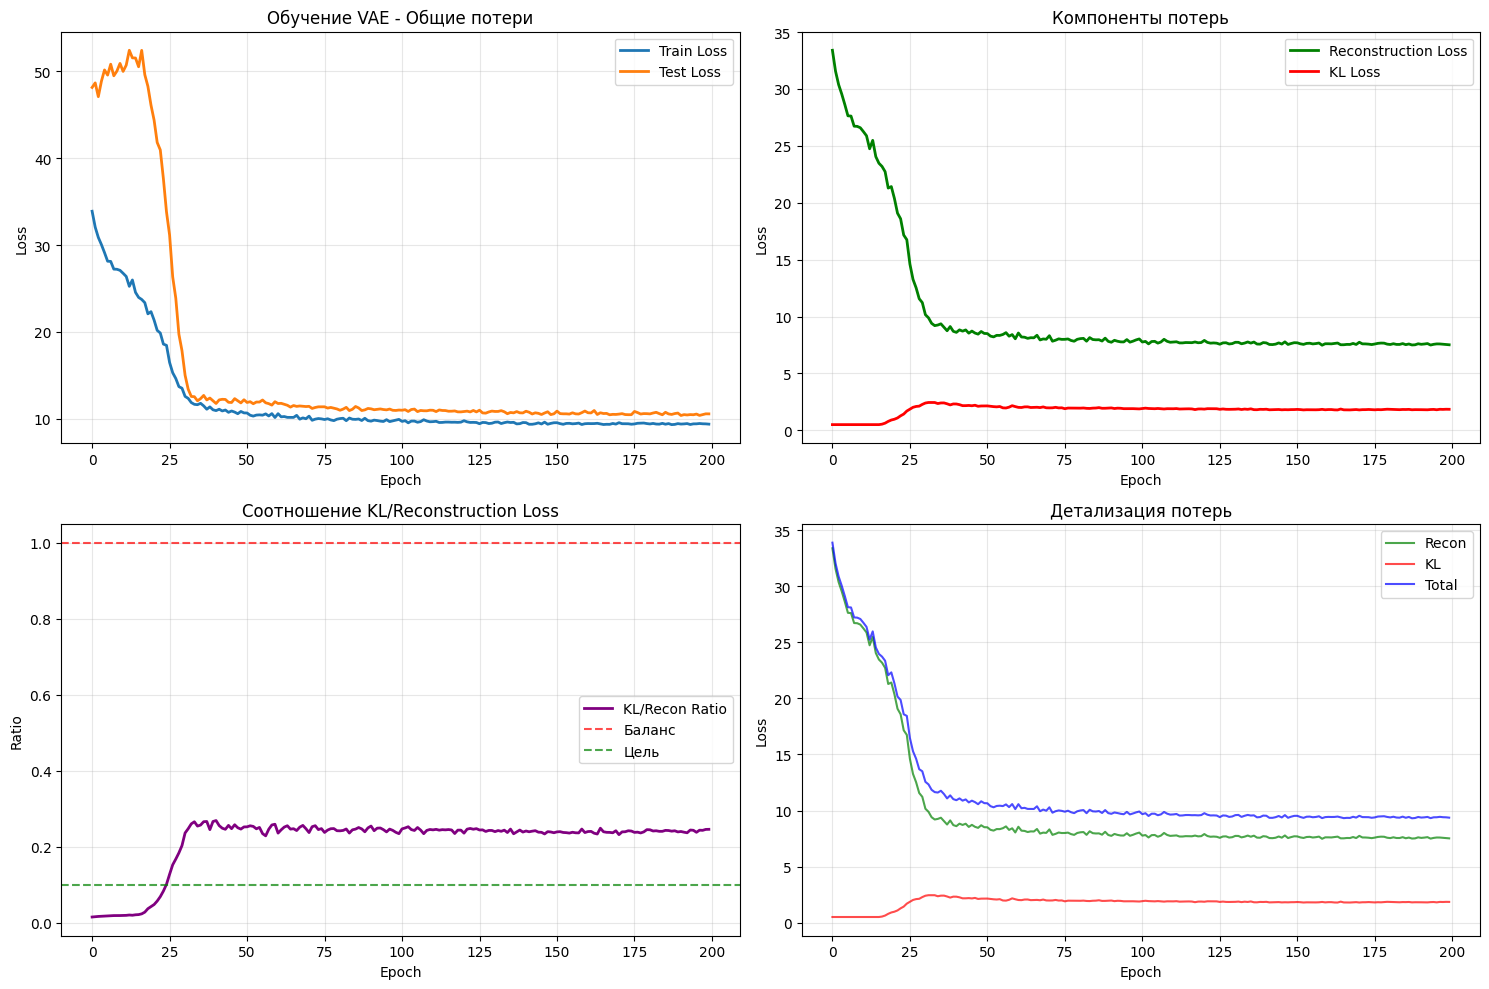

Результаты:
 - Лучший Test Loss: 10.3610
 - Final Reconstruction Loss: 7.5165
 - Final KL Loss: 1.8469
 - Final KL/Recon Ratio: 0.25

Архитектура:
 - Входная размерность: 7
 - Латентная размерность: 1
 - Скрытый слой: 16 нейронов
 - Всего параметров: 313

Сохраненные файлы:
student_model_vae_best.pth - лучшая модель
student_model_vae_final.pth - финальная модель
student_model_vae_history.pth - история обучения
vae_final_training_results.png - графики обучения


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

class StudentVAE(nn.Module):
    
    # Финальная архитектура VAE для данных студентов
    
    def __init__(self, input_dim, hidden_dim=16, latent_dim=1):
        super(StudentVAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # Латентное пространство
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss_free_bits(recon_x, x, mu, logvar, free_bits_threshold=0.5):
    
    # Free Bits VAE loss function для предотвращения collapse латентного пространства

    recon_loss = nn.MSELoss(reduction='mean')(recon_x, x) * x.size(0)
    
    kl_per_latent = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    kl_per_latent = torch.mean(kl_per_latent, dim=0)
    
    kl_loss = torch.sum(torch.max(kl_per_latent, 
                                 torch.tensor(free_bits_threshold).to(kl_per_latent.device)))
    
    total_loss = recon_loss + kl_loss
    
    return total_loss, recon_loss, kl_loss

def train_final_vae(model, train_loader, test_loader, epochs=200, lr=1e-3, free_bits=0.5, model_name='student_vae_final'):
    
    # Функция обучения VAE
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # История обучения
    train_losses = []
    test_losses = []
    recon_losses = []
    kl_losses = []
    kl_recon_ratios = []
    
    best_test_loss = float('inf')
    best_epoch = 0
    
    print("Запуск обучения")
    print(f"Параметры:")
    print(f" - Epochs: {epochs}")
    print(f" - Learning rate: {lr}")
    print(f" - Free bits threshold: {free_bits}")
    print(f" - Latent dimension: {model.latent_dim}")
    print(f" - Parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(epochs):
        # Обучение 
        model.train()
        train_loss = 0
        recon_loss_train = 0
        kl_loss_train = 0
        batch_count = 0
        
        for batch in train_loader:
            x = batch[0]
            optimizer.zero_grad()
            
            recon_batch, mu, logvar = model(x)
            loss, recon_loss, kl_loss = vae_loss_free_bits(recon_batch, x, mu, logvar, free_bits)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            recon_loss_train += recon_loss.item()
            kl_loss_train += kl_loss.item()
            batch_count += 1
        
        # Средние значения за эпоху
        avg_train_loss = train_loss / batch_count
        avg_recon = recon_loss_train / batch_count
        avg_kl = kl_loss_train / batch_count
        kl_recon_ratio = avg_kl / avg_recon if avg_recon > 0 else 0
        
        # Валидация 
        model.eval()
        test_loss = 0
        test_batch_count = 0
        
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0]
                recon_batch, mu, logvar = model(x)
                loss, _, _ = vae_loss_free_bits(recon_batch, x, mu, logvar, free_bits)
                test_loss += loss.item()
                test_batch_count += 1
        
        avg_test_loss = test_loss / test_batch_count
        
        # Сохранение истории
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        recon_losses.append(avg_recon)
        kl_losses.append(avg_kl)
        kl_recon_ratios.append(kl_recon_ratio)
        
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            best_epoch = epoch
            
            best_model_state = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'test_loss': avg_test_loss,
                'recon_loss': avg_recon,
                'kl_loss': avg_kl,
                'kl_recon_ratio': kl_recon_ratio,
                'model_architecture': {
                    'input_dim': model.input_dim,
                    'latent_dim': model.latent_dim,
                    'hidden_dim': 16  
                }
            }
            
            torch.save(best_model_state, f'{model_name}_best.pth')
            print(f'Новая лучшая модель! Epoch: {epoch}, Test Loss: {avg_test_loss:.4f}')
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3d}: '
                  f'Train Loss: {avg_train_loss:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, '
                  f'Recon: {avg_recon:.4f}, '
                  f'KL: {avg_kl:.4f}, '
                  f'KL/Recon: {kl_recon_ratio:.2f}')
    
    final_model_state = {
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'test_loss': avg_test_loss,
        'recon_loss': avg_recon,
        'kl_loss': avg_kl,
        'kl_recon_ratio': kl_recon_ratio,
        'training_history': {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'recon_losses': recon_losses,
            'kl_losses': kl_losses,
            'kl_recon_ratios': kl_recon_ratios
        },
        'model_architecture': {
            'input_dim': model.input_dim,
            'latent_dim': model.latent_dim,
            'hidden_dim': 16
        }
    }
    
    torch.save(final_model_state, f'{model_name}_final.pth')
    
    # История обучения отдельно
    training_history = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'recon_losses': recon_losses,
        'kl_losses': kl_losses,
        'kl_recon_ratios': kl_recon_ratios,
        'best_epoch': best_epoch,
        'best_test_loss': best_test_loss
    }
    
    torch.save(training_history, f'{model_name}_history.pth')
    
    return train_losses, test_losses, recon_losses, kl_losses, kl_recon_ratios

def plot_training_results(train_losses, test_losses, recon_losses, kl_losses, kl_recon_ratios):

    plt.figure(figsize=(15, 10))
    
    # Общие потери
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(test_losses, label='Test Loss', linewidth=2)
    plt.title('Обучение VAE - Общие потери')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Компоненты потерь
    plt.subplot(2, 2, 2)
    plt.plot(recon_losses, label='Reconstruction Loss', color='green', linewidth=2)
    plt.plot(kl_losses, label='KL Loss', color='red', linewidth=2)
    plt.title('Компоненты потерь')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Соотношение KL/Recon
    plt.subplot(2, 2, 3)
    plt.plot(kl_recon_ratios, label='KL/Recon Ratio', color='purple', linewidth=2)
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Баланс')
    plt.axhline(y=0.1, color='green', linestyle='--', alpha=0.7, label='Цель')
    plt.title('Соотношение KL/Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Детализированный вид
    plt.subplot(2, 2, 4)
    plt.plot(recon_losses, label='Recon', color='green', alpha=0.7)
    plt.plot(kl_losses, label='KL', color='red', alpha=0.7)
    plt.plot(train_losses, label='Total', color='blue', alpha=0.7)
    plt.title('Детализация потерь')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('vae_final_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def print_final_report(model, train_losses, test_losses, recon_losses, kl_losses, kl_recon_ratios):
    
    # Финальный отчет о обучении
    
    final_recon = recon_losses[-1]
    final_kl = kl_losses[-1]
    final_ratio = kl_recon_ratios[-1]
    best_test_loss = min(test_losses)
    
    print(f"Результаты:")
    print(f" - Лучший Test Loss: {best_test_loss:.4f}")
    print(f" - Final Reconstruction Loss: {final_recon:.4f}")
    print(f" - Final KL Loss: {final_kl:.4f}")
    print(f" - Final KL/Recon Ratio: {final_ratio:.2f}")
    
    print(f"\nАрхитектура:")
    print(f" - Входная размерность: {model.input_dim}")
    print(f" - Латентная размерность: {model.latent_dim}")
    print(f" - Скрытый слой: 16 нейронов")
    print(f" - Всего параметров: {sum(p.numel() for p in model.parameters()):,}")
    
    print(f"\nСохраненные файлы:")
    print(f"{model_name}_best.pth - лучшая модель")
    print(f"{model_name}_final.pth - финальная модель")
    print(f"{model_name}_history.pth - история обучения")
    print(f"vae_final_training_results.png - графики обучения")
    
# Запуск обучения
if __name__ == "__main__":

    input_dim = 7  
    batch_size = 32
    
    # Создание модели
    model = StudentVAE(
        input_dim=input_dim,
        hidden_dim=16,
        latent_dim=1  # Оптимальное значение по результатам экспериментов
    )
    
    # Обучение модели
    model_name = "student_model_vae"
    
    train_losses, test_losses, recon_losses, kl_losses, kl_recon_ratios = train_final_vae(
        model=model,
        train_loader=train_loader,  
        test_loader=test_loader,   
        epochs=200,
        lr=1e-3,
        free_bits=0.5,
        model_name=model_name
    )
    
    # Визуализация результатов
    plot_training_results(train_losses, test_losses, recon_losses, kl_losses, kl_recon_ratios)
    
    # Финальный отчет
    print_final_report(model, train_losses, test_losses, recon_losses, kl_losses, kl_recon_ratios)

Анализ латентного пространства
Латентные представления train: (240, 1)
Латентные представления test: (60, 1)
y_train shape: (240,)
y_test shape: (60,)

Размерности для визуализации:
latent_train_1d shape: (240,)
latent_test_1d shape: (60,)


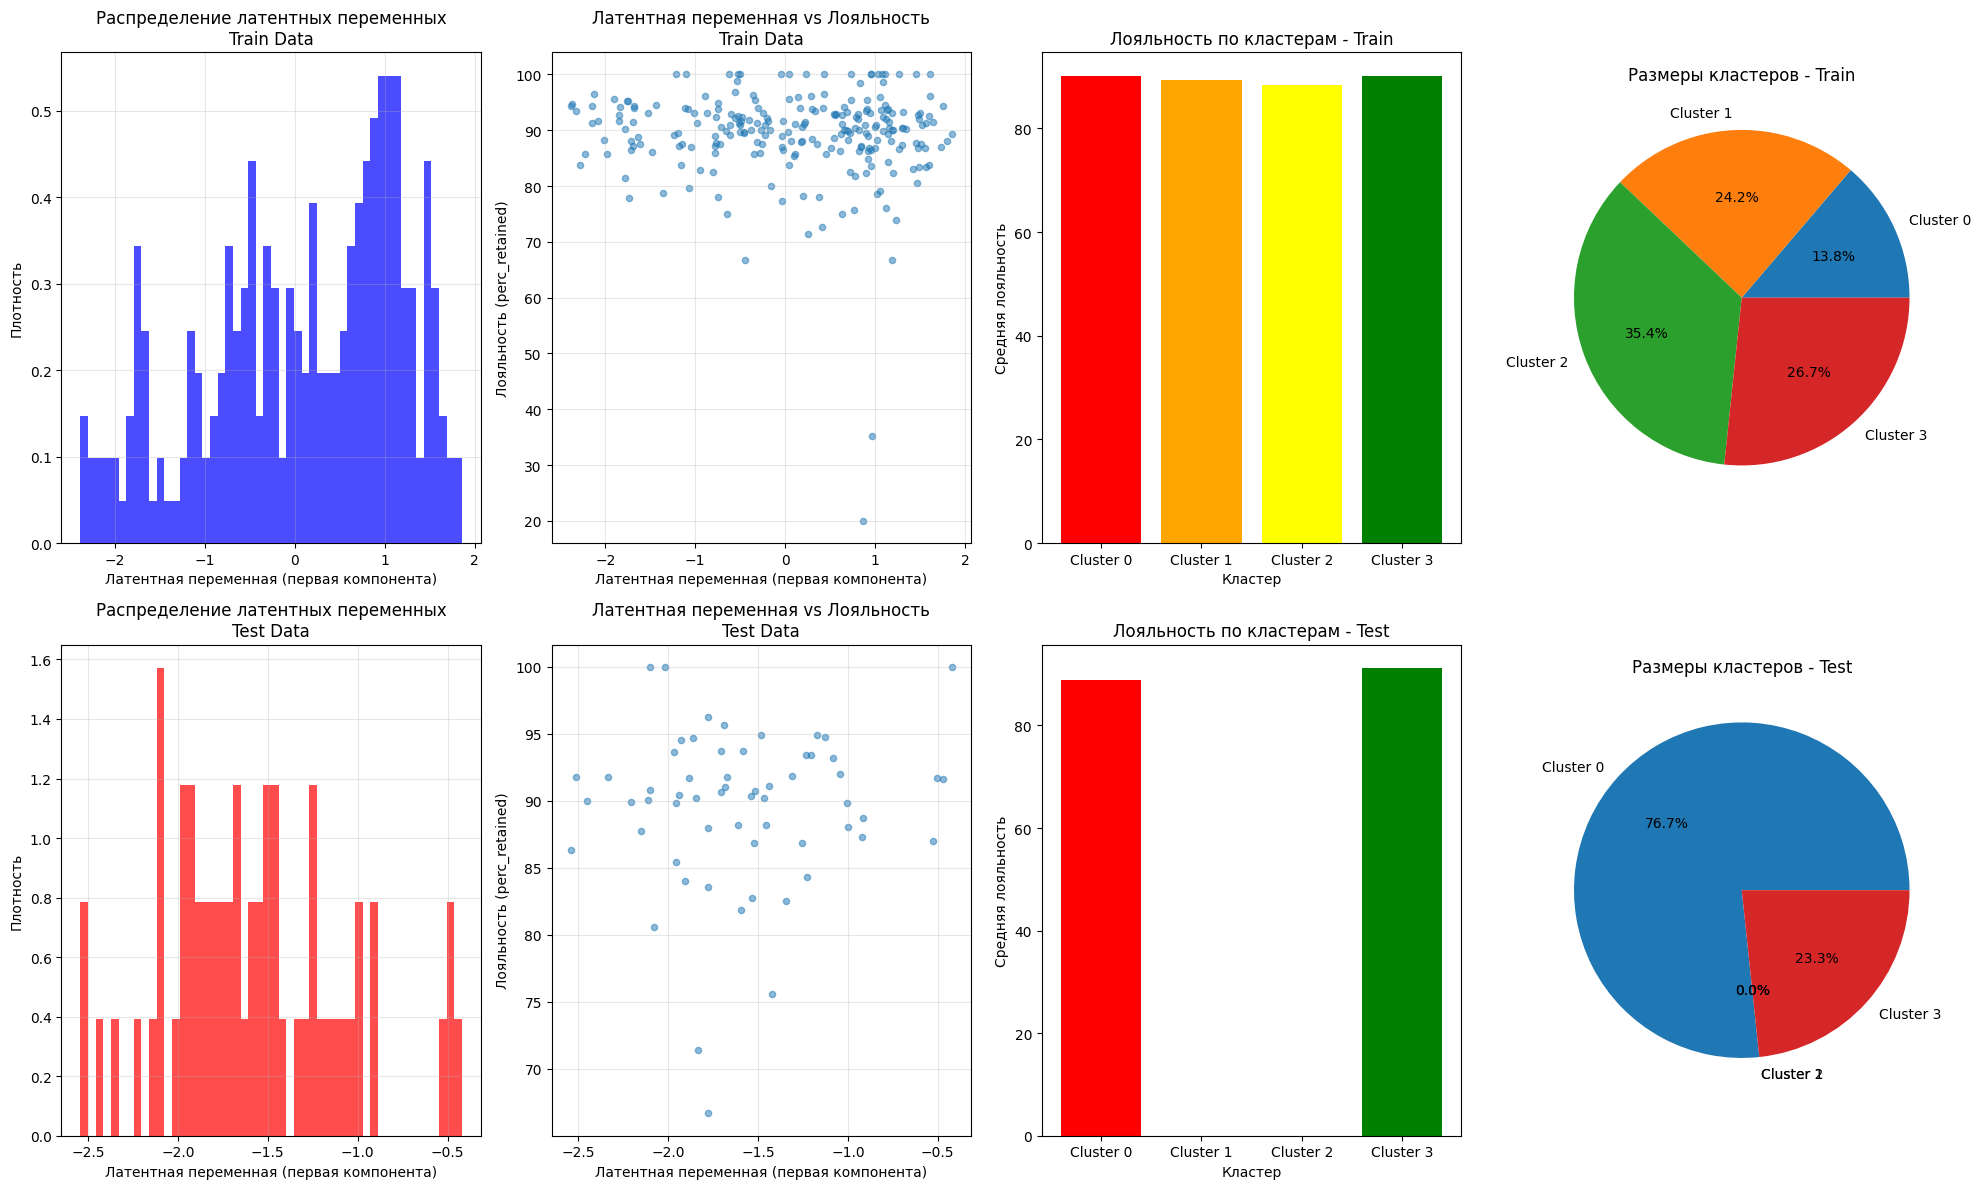

Анализ кластеров в латентном пространстве

КЛАСТЕР 0:
Размер (train): 33 samples
Размер (test): 46 samples
Диапазон латентных значений: -2.384 - -1.237
Средняя лояльность (train): 90.112
Средняя лояльность (test): 88.952

КЛАСТЕР 1:
Размер (train): 58 samples
Размер (test): 0 samples
Диапазон латентных значений: -0.045 - 0.779
Средняя лояльность (train): 89.230
Средняя лояльность (test): нет данных

КЛАСТЕР 2:
Размер (train): 85 samples
Размер (test): 0 samples
Диапазон латентных значений: 0.786 - 1.856
Средняя лояльность (train): 88.370
Средняя лояльность (test): нет данных

КЛАСТЕР 3:
Размер (train): 64 samples
Размер (test): 14 samples
Диапазон латентных значений: -1.210 - -0.155
Средняя лояльность (train): 90.178
Средняя лояльность (test): 91.196


Анализ качества реконструкции
X_train shape: (1352, 7)
recon_train shape: (240, 7)
X_test shape: (338, 7)
recon_test shape: (60, 7)
Среднеквадратичная ошибка реконструкции Train: 1.6169
Среднеквадратичная ошибка реконструкции Test: 1.836

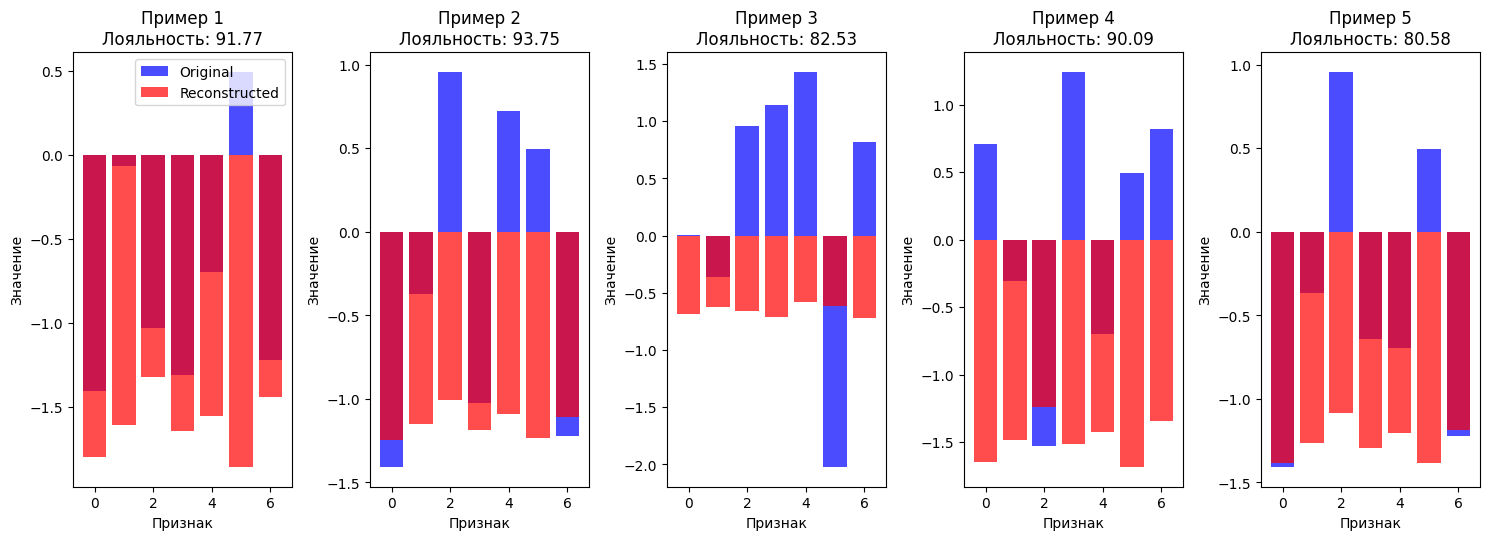



Корреляционный анализ
Корреляция латентной переменной с лояльностью (Train): -0.0770
Корреляция латентной переменной с лояльностью (Test): 0.0814


In [37]:
def analyze_latent_space(model, dataloader):
    """Получает латентные представления для всех данных в DataLoader"""
    model.eval()
    latent_vectors = []
    reconstructions = []
    mus = []
    logvars = []
    
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0]
            recon_x, mu, logvar = model(x)
            z = model.reparameterize(mu, logvar)
            
            latent_vectors.append(z.numpy())
            reconstructions.append(recon_x.numpy())
            mus.append(mu.numpy())
            logvars.append(logvar.numpy())
    
    if latent_vectors:
        latent_vectors = np.vstack(latent_vectors)
        reconstructions = np.vstack(reconstructions)
        mus = np.vstack(mus)
        logvars = np.vstack(logvars)
    else:
        latent_vectors = np.array([])
        reconstructions = np.array([])
        mus = np.array([])
        logvars = np.array([])
    
    return latent_vectors, reconstructions, mus, logvars

# Получение латентных представлений
print("Анализ латентного пространства")
latent_train, recon_train, mu_train, logvar_train = analyze_latent_space(model, train_loader)
latent_test, recon_test, mu_test, logvar_test = analyze_latent_space(model, test_loader)

print(f"Латентные представления train: {latent_train.shape}")
print(f"Латентные представления test: {latent_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Для гистограмм: используем первую латентную переменную
if latent_train.size > 0 and latent_train.ndim > 1:
    latent_train_1d = latent_train[:, 0] if latent_train.shape[1] > 0 else latent_train.flatten()
elif latent_train.size > 0:
    latent_train_1d = latent_train.flatten()
else:
    latent_train_1d = np.array([])

if latent_test.size > 0 and latent_test.ndim > 1:
    latent_test_1d = latent_test[:, 0] if latent_test.shape[1] > 0 else latent_test.flatten()
elif latent_test.size > 0:
    latent_test_1d = latent_test.flatten()
else:
    latent_test_1d = np.array([])

print(f"\nРазмерности для визуализации:")
print(f"latent_train_1d shape: {latent_train_1d.shape}")
print(f"latent_test_1d shape: {latent_test_1d.shape}")

# Проверяем и исправляем размерности
if len(latent_train_1d) != len(y_train):
    print(f"\nВнимание: Размерности latent_train_1d и y_train не совпадают!")
    print(f"latent_train_1d: {len(latent_train_1d)}, y_train: {len(y_train)}")
    if len(latent_train_1d) < len(y_train):
        y_train = y_train[:len(latent_train_1d)]
        X_train_vis = X_train[:len(latent_train_1d)]
        print(f"Обрезан y_train до {len(y_train)} элементов")

if len(latent_test_1d) != len(y_test):
    print(f"Внимание: Размерности latent_test_1d и y_test не совпадают!")
    print(f"latent_test_1d: {len(latent_test_1d)}, y_test: {len(y_test)}")
    if len(latent_test_1d) < len(y_test):
        y_test = y_test[:len(latent_test_1d)]
        X_test_vis = X_test[:len(latent_test_1d)]
        print(f"Обрезан y_test до {len(y_test)} элементов")

# Кластеризация в латентном пространстве (если есть данные)
if latent_train.size > 0:
    kmeans = KMeans(n_clusters=4, random_state=42)
    clusters_train = kmeans.fit_predict(latent_train)
    clusters_test = kmeans.predict(latent_test) if latent_test.size > 0 else np.array([])
else:
    print("Нет данных для кластеризации")
    clusters_train = np.array([])
    clusters_test = np.array([])

# Визуализация результатов (только если есть данные)
if latent_train_1d.size > 0 and latent_test_1d.size > 0:
    plt.figure(figsize=(20, 12))

    # Распределение латентных переменных - Train
    plt.subplot(2, 4, 1)
    plt.hist(latent_train_1d, bins=50, alpha=0.7, color='blue', density=True)
    plt.xlabel('Латентная переменная (первая компонента)')
    plt.ylabel('Плотность')
    plt.title('Распределение латентных переменных\nTrain Data')
    plt.grid(True, alpha=0.3)

    # Латентные переменные vs Лояльность - Train
    plt.subplot(2, 4, 2)
    plt.scatter(latent_train_1d, y_train, alpha=0.5, s=20)
    plt.xlabel('Латентная переменная (первая компонента)')
    plt.ylabel('Лояльность (perc_retained)')
    plt.title('Латентная переменная vs Лояльность\nTrain Data')
    plt.grid(True, alpha=0.3)

    # Распределение лояльности по кластерам - Train
    plt.subplot(2, 4, 3)
    cluster_retention = []
    cluster_sizes = []
    cluster_ranges = []

    if clusters_train.size > 0:
        for i in range(4):
            cluster_mask = clusters_train == i
            cluster_data = latent_train[cluster_mask]
            if len(y_train[cluster_mask]) > 0:
                cluster_retention.append(y_train[cluster_mask].mean())
            else:
                cluster_retention.append(0)
            cluster_sizes.append(np.sum(cluster_mask))
            # Для диапазона берем первую компоненту
            if cluster_data.shape[0] > 0 and cluster_data.ndim > 1 and cluster_data.shape[1] > 0:
                cluster_ranges.append((cluster_data[:, 0].min(), cluster_data[:, 0].max()))
            elif cluster_data.shape[0] > 0:
                cluster_ranges.append((cluster_data.min(), cluster_data.max()))
            else:
                cluster_ranges.append((0, 0))
    else:
        cluster_retention = [0, 0, 0, 0]
        cluster_sizes = [0, 0, 0, 0]
        cluster_ranges = [(0, 0), (0, 0), (0, 0), (0, 0)]

    plt.bar(range(4), cluster_retention, color=['red', 'orange', 'yellow', 'green'])
    plt.xlabel('Кластер')
    plt.ylabel('Средняя лояльность')
    plt.title('Лояльность по кластерам - Train')
    plt.xticks(range(4), [f'Cluster {i}' for i in range(4)])

    # Размеры кластеров - Train
    plt.subplot(2, 4, 4)
    plt.pie(cluster_sizes, labels=[f'Cluster {i}' for i in range(4)], autopct='%1.1f%%')
    plt.title('Размеры кластеров - Train')

    # Распределение латентных переменных - Test
    plt.subplot(2, 4, 5)
    plt.hist(latent_test_1d, bins=50, alpha=0.7, color='red', density=True)
    plt.xlabel('Латентная переменная (первая компонента)')
    plt.ylabel('Плотность')
    plt.title('Распределение латентных переменных\nTest Data')
    plt.grid(True, alpha=0.3)

    # Латентные переменные vs Лояльность - Test
    plt.subplot(2, 4, 6)
    plt.scatter(latent_test_1d, y_test, alpha=0.5, s=20)
    plt.xlabel('Латентная переменная (первая компонента)')
    plt.ylabel('Лояльность (perc_retained)')
    plt.title('Латентная переменная vs Лояльность\nTest Data')
    plt.grid(True, alpha=0.3)

    # Распределение лояльности по кластерам - Test
    plt.subplot(2, 4, 7)
    test_cluster_retention = []
    if clusters_test.size > 0:
        for i in range(4):
            cluster_mask = clusters_test == i
            if np.sum(cluster_mask) > 0 and len(y_test[cluster_mask]) > 0:
                test_cluster_retention.append(y_test[cluster_mask].mean())
            else:
                test_cluster_retention.append(np.nan)
    else:
        test_cluster_retention = [np.nan, np.nan, np.nan, np.nan]

    plt.bar(range(4), test_cluster_retention, color=['red', 'orange', 'yellow', 'green'])
    plt.xlabel('Кластер')
    plt.ylabel('Средняя лояльность')
    plt.title('Лояльность по кластерам - Test')
    plt.xticks(range(4), [f'Cluster {i}' for i in range(4)])

    # Размеры кластеров - Test
    plt.subplot(2, 4, 8)
    test_cluster_sizes = [np.sum(clusters_test == i) for i in range(4)] if clusters_test.size > 0 else [0, 0, 0, 0]
    plt.pie(test_cluster_sizes, labels=[f'Cluster {i}' for i in range(4)], autopct='%1.1f%%')
    plt.title('Размеры кластеров - Test')

    plt.tight_layout()
    plt.show()
else:
    print("Недостаточно данных для визуализации")

# Дополнительный анализ: характеристики кластеров
if clusters_train.size > 0:
    print("Анализ кластеров в латентном пространстве")

    for i in range(4):
        train_mask = clusters_train == i
        test_mask = clusters_test == i if clusters_test.size > 0 else np.array([False] * len(latent_test_1d))
        
        print(f"\nКЛАСТЕР {i}:")
        print(f"Размер (train): {np.sum(train_mask)} samples")
        print(f"Размер (test): {np.sum(test_mask)} samples")
        print(f"Диапазон латентных значений: {cluster_ranges[i][0]:.3f} - {cluster_ranges[i][1]:.3f}")
        print(f"Средняя лояльность (train): {cluster_retention[i]:.3f}")
        if i < len(test_cluster_retention) and not np.isnan(test_cluster_retention[i]):
            print(f"Средняя лояльность (test): {test_cluster_retention[i]:.3f}")
        else:
            print(f"Средняя лояльность (test): нет данных")

# Анализ качества реконструкции
print("\n" + "")
print("Анализ качества реконструкции")

# Проверяем размерности для MSE
print(f"X_train shape: {X_train.shape}")
print(f"recon_train shape: {recon_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"recon_test shape: {recon_test.shape}")

# Соответствующие части данных для расчета MSE
if len(X_train) > len(recon_train):
    X_train_mse = X_train[:len(recon_train)]
    recon_train_mse = recon_train
else:
    X_train_mse = X_train
    recon_train_mse = recon_train[:len(X_train)]

if len(X_test) > len(recon_test):
    X_test_mse = X_test[:len(recon_test)]
    recon_test_mse = recon_test
else:
    X_test_mse = X_test
    recon_test_mse = recon_test[:len(X_test)]

# Вычисление MSE для реконструкции (только если есть данные)
if X_train_mse.size > 0 and recon_train_mse.size > 0:
    mse_train = np.mean((X_train_mse - recon_train_mse) ** 2)
    print(f"Среднеквадратичная ошибка реконструкции Train: {mse_train:.4f}")
else:
    print("Нет данных для расчета MSE train")

if X_test_mse.size > 0 and recon_test_mse.size > 0:
    mse_test = np.mean((X_test_mse - recon_test_mse) ** 2)
    print(f"Среднеквадратичная ошибка реконструкции Test: {mse_test:.4f}")
else:
    print("Нет данных для расчета MSE test")

# Визуализация нескольких примеров реконструкции
print(f"\n" + "")
print(f"Визуализация нескольких примеров реконструкции")

if recon_test.size > 0 and X_test.size > 0:
    n_samples_to_show = min(5, len(recon_test))
    if n_samples_to_show > 0:
        # Индексы только из доступного диапазона
        sample_indices = np.random.choice(len(recon_test), n_samples_to_show, replace=False)
        
        plt.figure(figsize=(15, 10))
        for i, idx in enumerate(sample_indices):
            plt.subplot(2, 5, i + 1)
            
            if idx < len(X_test) and idx < len(recon_test) and idx < len(y_test):
                # Оригинальные данные
                plt.bar(range(len(X_test[idx])), X_test[idx], alpha=0.7, label='Original', color='blue')
                
                # Реконструированные данные
                plt.bar(range(len(recon_test[idx])), recon_test[idx], alpha=0.7, label='Reconstructed', color='red')
                
                plt.title(f'Пример {i+1}\nЛояльность: {y_test[idx]:.2f}')
                plt.xlabel('Признак')
                plt.ylabel('Значение')
                if i == 0:
                    plt.legend()
            else:
                plt.text(0.5, 0.5, f'Нет данных\nдля индекса {idx}', 
                        horizontalalignment='center', verticalalignment='center',
                        transform=plt.gca().transAxes)
                plt.title(f'Пример {i+1}')
            
        plt.tight_layout()
        plt.show()
    else:
        print("Нет данных для визуализации реконструкции")
else:
    print("Недостаточно данных для визуализации реконструкции")

# Анализ взаимосвязи латентной переменной с лояльностью
print("\n" + "")
print("Корреляционный анализ")

if latent_train_1d.size > 0 and len(latent_train_1d) == len(y_train):
    corr_train = np.corrcoef(latent_train_1d, y_train)[0, 1]
    print(f"Корреляция латентной переменной с лояльностью (Train): {corr_train:.4f}")
else:
    print("Недостаточно данных для расчета корреляции Train")

if latent_test_1d.size > 0 and len(latent_test_1d) == len(y_test):
    corr_test = np.corrcoef(latent_test_1d, y_test)[0, 1]
    print(f"Корреляция латентной переменной с лояльностью (Test): {corr_test:.4f}")
else:
    print("Недостаточно данных для расчета корреляции Test")

if 'corr_train' in locals() and abs(corr_train) > 0.3:
    from sklearn.linear_model import LinearRegression
    
    # Простая линейная регрессия: латентная переменная -> лояльность
    reg = LinearRegression()
    reg.fit(latent_train_1d.reshape(-1, 1), y_train)
    
    train_score = reg.score(latent_train_1d.reshape(-1, 1), y_train)
    test_score = reg.score(latent_test_1d.reshape(-1, 1), y_test) if latent_test_1d.size > 0 else 0
    
    print(f"\nПрогноз лояльности:")
    print(f"R^2 score (train): {train_score:.4f}")
    print(f"R^2 score (test):  {test_score:.4f}")
    print(f"Коэффициент: {reg.coef_[0]:.4f}")
    
    # Визуализация регрессии
    if latent_train_1d.size > 0:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(latent_train_1d, y_train, alpha=0.5, label='Данные')
        x_range = np.linspace(latent_train_1d.min(), latent_train_1d.max(), 100).reshape(-1, 1)
        plt.plot(x_range, reg.predict(x_range), color='red', linewidth=2, label='Регрессия')
        plt.xlabel('Латентная переменная (первая компонента)')
        plt.ylabel('Лояльность')
        plt.title(f'Прогноз лояльности (Train)\nR^2 = {train_score:.3f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        if latent_test_1d.size > 0:
            plt.subplot(1, 2, 2)
            plt.scatter(latent_test_1d, y_test, alpha=0.5, label='Данные')
            plt.plot(x_range, reg.predict(x_range), color='red', linewidth=2, label='Регрессия')
            plt.xlabel('Латентная переменная (первая компонента)')
            plt.ylabel('Лояльность')
            plt.title(f'Прогноз лояльности (Test)\nR^2 = {test_score:.3f}')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

FEATURE_NAMES = {
    0: "Активность на платформе",
    1: "Успеваемость", 
    2: "Посещаемость занятий",
    3: "Вовлеченность в сообщество",
    4: "Использование доп. материалов",
    5: "Качество выполненных работ",
    6: "Продолжительность обучения"
}

FEATURE_DESCRIPTIONS = {
    0: "Частота логинов и активность на образовательной платформе",
    1: "Средний балл по курсам и тестам",
    2: "Регулярность посещения онлайн/офлайн занятий", 
    3: "Участие в форумах, группах, мероприятиях",
    4: "Использование дополнительных материалов и ресурсов",
    5: "Средняя оценка за домашние задания и проекты",
    6: "Общее время обучения на платформе"
}

class StudentVAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=16, latent_dim=1):
        super(StudentVAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Энкодер
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
        )
        
        # Латентное пространство
        self.fc_mu = torch.nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = torch.nn.Linear(hidden_dim, latent_dim)
        
        # Декодер
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, input_dim)
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def load_trained_model(model_path, input_dim=7):

    # Загрузка обученной модели

    model = StudentVAE(input_dim=input_dim, hidden_dim=16, latent_dim=1)
    checkpoint = torch.load(model_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

def create_student_from_features(**kwargs):

    # Значения по умолчанию (средние)
    default_features = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    
    for feature_name, value in kwargs.items():
        if feature_name in ["activity", "activity_score"]:
            default_features[0] = value
        elif feature_name in ["performance", "grades"]:
            default_features[1] = value
        elif feature_name in ["attendance", "participation"]:
            default_features[2] = value
        elif feature_name in ["engagement", "community"]:
            default_features[3] = value
        elif feature_name in ["materials", "resources"]:
            default_features[4] = value
        elif feature_name in ["quality", "homework"]:
            default_features[5] = value
        elif feature_name in ["duration", "length"]:
            default_features[6] = value
    
    return default_features

def analyze_student_profile(student_data):
    
    # Анализ профиля студента

    avg_score = np.mean(student_data)
    min_score = np.min(student_data)
    max_score = np.max(student_data)
    weak_features = np.sum(student_data < -1.0)  # Количество очень слабых признаков
    strong_features = np.sum(student_data > 1.0)  # Количество очень сильных признаков
    
    return {
        'avg_score': avg_score,
        'min_score': min_score,
        'max_score': max_score,
        'weak_features_count': weak_features,
        'strong_features_count': strong_features,
        'overall_profile': get_overall_profile(avg_score, weak_features, strong_features)
    }

def get_overall_profile(avg_score, weak_features, strong_features):

    if weak_features >= 4:
        return "Критический"
    elif avg_score < -0.8:
        return "Низкий"
    elif avg_score < -0.3:
        return "Ниже среднего"
    elif avg_score < 0.3:
        return "Средний"
    elif avg_score < 0.8:
        return "Выше среднего"
    else:
        return "высокий"

def predict_student_segment(model, student_data, student_name="Студент"):
    
    model.eval()
    with torch.no_grad():
        student_tensor = torch.FloatTensor(student_data).unsqueeze(0)
        recon, mu, logvar = model(student_tensor)
        latent_value = mu.item()
        
        # Анализ профиля студента
        profile = analyze_student_profile(student_data)
        avg_score = profile['avg_score']
        weak_features = profile['weak_features_count']
        min_score = profile['min_score']
        strong_features = profile['strong_features_count']
        
        if weak_features >= 4 or min_score < -1.5:
            # Много слабых признаков или хотя бы один очень слабый
            cluster = 0
            segment_name = "Проблемные студенты"
            risk_level = "Высокий риск"
            base_loyalty = 82.0
            description = "Студенты с критически низкими показателями по ключевым метрикам"
            actions = [
                "- Срочные персональные консультации",
                "- Индивидуальный план восстановления",
                "- Повышенное внимание куратора",
                "- Специальные мотивационные программы"
            ]
        elif avg_score < -0.5:
            cluster = 3  
            segment_name = "Рискованные студенты"
            risk_level = "Средний риск"  # Исправлено: "рис" → "риск"
            base_loyalty = 86.0
            description = "Студенты с нестабильными или низкими показателями"
            actions = [
                "- Групповые занятия и воркшопы",
                "- Регулярный мониторинг прогресса",
                "- Дополнительные учебные материалы",
                "- Мотивационные рассылки"
            ]
        elif avg_score > 0.8 and strong_features >= 3 and min_score > -0.3:
            cluster = 2
            segment_name = "Перспективные студенты" 
            risk_level = "Очень низкий риск"
            base_loyalty = 94.0
            description = "Студенты со стабильно высокими показателями"
            actions = [
                "- Премиальные программы обучения",
                "- Реферальные бонусы",
                "- Участие в менторских программах",
                "- Приоритетный доступ к новым курсам"
            ]
        else:
            cluster = 1
            segment_name = "Обычные студенты"
            risk_level = "Низкий риск"
            base_loyalty = 90.0
            description = "Студенты со стабильными средними показателями"
            actions = [
                "- Стандартные программы обучения",
                "- Групповые активности",
                "- Регулярные опросы удовлетворенности",
                "- Доступ ко всем базовым ресурсам"
            ]
        
        # Лояльность на основе латентного значения
        loyalty_adjustment = latent_value * 1.5  
        predicted_loyalty = max(75, min(98, base_loyalty + loyalty_adjustment))
        
        # Анализ сильных и слабых сторон
        feature_analysis = analyze_features_detailed(student_data)
        
        # ВАЖНО: ВОЗВРАЩАЕМ РЕЗУЛЬТАТ!
        return {
            'student_name': student_name,
            'latent_value': latent_value,
            'cluster': cluster,
            'segment_name': segment_name,
            'risk_level': risk_level,
            'predicted_loyalty': round(predicted_loyalty, 1),
            'description': description,
            'recommended_actions': actions,
            'profile_analysis': profile,
            'feature_analysis': feature_analysis,
            'reconstruction': recon.squeeze().numpy()
        }

def analyze_features_detailed(student_data):

    analysis = {
        'strengths': [],
        'weaknesses': [],
        'neutral': [],
        'recommendations': []
    }
    
    for i, value in enumerate(student_data):
        feature_name = FEATURE_NAMES[i]
        
        if value > 1.0:
            analysis['strengths'].append(f"{feature_name}: {value:.2f} (сильно выше среднего)")
        elif value > 0.5:
            analysis['strengths'].append(f"{feature_name}: {value:.2f} (выше среднего)")
        elif value < -1.0:
            analysis['weaknesses'].append(f"{feature_name}: {value:.2f} (критически низкий)")
        elif value < -0.5:
            analysis['weaknesses'].append(f"{feature_name}: {value:.2f} (ниже среднего)")
        else:
            analysis['neutral'].append(f"{feature_name}: {value:.2f} (в норме)")
    
    # Рекомендации на основе анализа
    if len(analysis['weaknesses']) >= 3:
        analysis['recommendations'].append("Требуется комплексная программа поддержки")
    if any("Активность" in strength for strength in analysis['strengths']):
        analysis['recommendations'].append("Можно привлекать к менторской деятельности")
    if any("Успеваемость" in weakness for weakness in analysis['weaknesses']):
        analysis['recommendations'].append("Рекомендуются дополнительные занятия")
    
    return analysis

def display_student_prediction(prediction):

    print(f"\n{''}")
    print(f"{prediction['student_name']}")
    print(f"{''}")
    
    print(f"\nСегмент: {prediction['segment_name']}")
    print(f"Латентный показатель: {prediction['latent_value']:.3f}")
    print(f"Уровень риска: {prediction['risk_level']}")
    print(f"Прогнозируемая лояльность: {prediction['predicted_loyalty']}%")
    print(f"{prediction['description']}")
    
    # Профиль студента
    profile = prediction['profile_analysis']
    print(f"\nОбщий профиль: {profile['overall_profile']}")
    print(f"Средний балл: {profile['avg_score']:.2f}")
    print(f"Сильных сторон: {profile['strong_features_count']}")
    print(f"Слабых сторон: {profile['weak_features_count']}")
    
    print(f"\nРекомендации для повышения лояльности:")
    for action in prediction['recommended_actions']:
        print(f"{action}")
    
    # Анализ признаков
    analysis = prediction['feature_analysis']
    if analysis['strengths']:
        print(f"\nСильные стороны:")
        for strength in analysis['strengths']:
            print(f" - {strength}")
    
    if analysis['weaknesses']:
        print(f"\nСлабые стороны:")
        for weakness in analysis['weaknesses']:
            print(f" - {weakness}")
    
    if analysis['neutral']:
        print(f"\nНормальные показатели:")
        for neutral in analysis['neutral'][:3]:
            print(f" - {neutral}")
    
    if analysis['recommendations']:
        print(f"\nДополнительные рекомендации:")
        for rec in analysis['recommendations']:
            print(f" - {rec}")


def predict_multiple_students(model, students_data, student_names=None):

    if student_names is None:
        student_names = [f"Студент {i+1}" for i in range(len(students_data))]
    
    results = []
    for i, (student_data, name) in enumerate(zip(students_data, student_names)):
        result = predict_student_segment(model, student_data, name)
        results.append(result)
    
    return results

def display_batch_predictions(predictions):

    
    summary = {
        "Проблемные студенты": 0,
        "Рискованные студенты": 0, 
        "Обычные студенты": 0,
        "Перспективные студенты": 0
    }
    
    for pred in predictions:
        summary[pred['segment_name']] += 1
        print(f"\n{pred['student_name']}:")
        print(f"{pred['segment_name']}")
        print(f"Лояльность: {pred['predicted_loyalty']}%")
        print(f"Риск: {pred['risk_level']}")
        print(f"Профиль: {pred['profile_analysis']['overall_profile']}")
    
    # Сводная статистика
    print(f"\nСтатистика:")
    total_students = len(predictions)
    for segment, count in summary.items():
        percentage = (count / total_students) * 100 if total_students > 0 else 0
        print(f"   {segment}: {count} студентов ({percentage:.1f}%)")


print("Загрузка обученной модели")
model = load_trained_model('student_model_vae_best.pth')

# Пример 1: Проблемный студент (должен быть в кластере 0)
print("\n1. Проблемный студент:")
problem_student = create_student_from_features(
    activity=-1.8,      # Очень низкая активность
    performance=-2.0,   # Критически низкая успеваемость  
    attendance=-1.5,    # Низкая посещаемость
    engagement=-1.2,    # Низкая вовлеченность
    materials=-0.8,     # Редко использует материалы
    quality=-1.0,       # Низкое качество работ
    duration=-0.5       # Короткое время обучения
)

pred1 = predict_student_segment(model, problem_student, "Алексей Петров (проблемный)")
display_student_prediction(pred1)

# Пример 2: Стандартный студент (должен быть в кластере 1)
print("\n2. Стандартный студент:")
standard_student = create_student_from_features(
    activity=0.3,       # Средняя активность
    performance=0.5,    # Хорошая успеваемость
    attendance=0.2,     # Регулярная посещаемость
    engagement=0.1,     # Умеренная вовлеченность
    materials=0.4,      # Использует материалы
    quality=0.3,        # Качество работ на уровне
    duration=0.6        # Нормальная продолжительность
)

pred2 = predict_student_segment(model, standard_student, "Мария Сидорова (обычная)")
display_student_prediction(pred2)

# Пример 3: Перспективный студент (должен быть в кластере 2)
print("\n3. Перспективный студент:")
top_student = create_student_from_features(
    activity=1.8,       # Высокая активность
    performance=2.1,    # Отличная успеваемость
    attendance=1.5,     # Идеальная посещаемость
    engagement=1.2,     # Активное участие
    materials=1.4,      # Использует все материалы
    quality=2.0,        # Высокое качество работ
    duration=1.3        # Длительное обучение
)

pred3 = predict_student_segment(model, top_student, "Дмитрий Иванов (перспективный)")
display_student_prediction(pred3)

# Пример 4: Рискованный студент (должен быть в кластере 3)
print("\n4. Рискованный студент:")
risky_student = create_student_from_features(
    activity=-1.2,      # Низкая активность
    performance=0.7,    # Но хорошая успеваемость
    attendance=-0.9,    # Низкая посещаемость
    engagement=-0.7,    # Слабая вовлеченность
    materials=0.2,      # Использует материалы
    quality=-0.6,       # Нестабильное качество
    duration=-0.8       # Короткое время
)

pred4 = predict_student_segment(model, risky_student, "Анна Козлова (рискованная)")
display_student_prediction(pred4)

test_students_data = [
    create_student_from_features(activity=-2.0, performance=-1.8, attendance=-1.5, engagement=-1.2, materials=-0.8, quality=-1.5, duration=-1.0),
    create_student_from_features(activity=0.5, performance=0.3, attendance=0.1, engagement=-0.2, materials=0.7, quality=-0.1, duration=0.4),
    create_student_from_features(activity=1.5, performance=1.8, attendance=2.1, engagement=1.5, materials=2.8, quality=1.2, duration=2.3),
    create_student_from_features(activity=-1.0, performance=-0.5, attendance=-1.2, engagement=-0.8, materials=-0.3, quality=-1.1, duration=-0.6),
    create_student_from_features(activity=0.8, performance=0.9, attendance=0.7, engagement=0.6, materials=0.5, quality=0.8, duration=1.1)
]

test_student_names = ["Иван Критический", "Петр Средний", "Ольга Низкая", "Сергей Рисковый", "Елена Стабильная-Перспективная"]

batch_predictions = predict_multiple_students(model, test_students_data, test_student_names)
display_batch_predictions(batch_predictions)

def interactive_student_test():

    print("Введите данные студента (от -3.0 до +3.0):")
    print("-3.0: Очень низкий показатель")
    print("0.0: Средний показатель")  
    print("+3.0: Очень высокий показатель")
    print("-" * 50)
    
    features = []
    for i in range(7):
        feature_name = FEATURE_NAMES[i]
        description = FEATURE_DESCRIPTIONS[i]
        while True:
            try:
                value = float(input(f"\n{feature_name}:\n{description}\nВведите значение: "))
                if -3.0 <= value <= 3.0:
                    features.append(value)
                    break
                else:
                    print("Ошибка: значение должно быть от -3.0 до +3.0")
            except ValueError:
                print("Ошибка: введите числовое значение")
    
    student_name = input("\nВведите имя студента: ")
    
    # предсказание
    student_data = np.array(features)
    prediction = predict_student_segment(model, student_data, student_name)
    display_student_prediction(prediction)
    
    return prediction


print("\n" + " ")
print("Инструкия по использованию системы")
print(" ")

print("""
1. Сегментация студентов:
   Проблемные студенты    - Критически низкие показатели (>3 слабых признаков)
   Рискованные студенты   - Нестабильные или низкие показатели (средний балл < -0.5)
   Стандартные студенты   - Стабильные средние показатели  
   Перспективные студенты - Высокие показатели по всем метрикам

2. Оценка признаков:
   -3.0 : Критически низкий показатель
   -1.5 : Низкий показатель
    0.0 : Средний показатель
   +1.5 : Высокий показатель  
   +3.0 : Очень высокий показатель

3. Рекомендации (опционально и для наглядности):
   Интенсивная индивидуальная поддержка
   Групповые программы и мониторинг
   Стандартные образовательные программы  
   Премиальные и менторские программы

4. Использование:
   student_data = create_student_from_features(
       activity=0.5,      # Активность на платформе
       performance=1.2,   # Успеваемость
       # остальные признаки
   )
   prediction = predict_student_segment(model, student_data, "Имя")
""")

# следующую строка для интерактивного тестирования:
# interactive_student_test()

Загрузка обученной модели

1. Проблемный студент:


Алексей Петров (проблемный)


Сегмент: Проблемные студенты
Латентный показатель: -1.962
Уровень риска: Высокий риск
Прогнозируемая лояльность: 79.1%
Студенты с критически низкими показателями по ключевым метрикам

Общий профиль: Критический
Средний балл: -1.26
Сильных сторон: 0
Слабых сторон: 4

Рекомендации для повышения лояльности:
- Срочные персональные консультации
- Индивидуальный план восстановления
- Повышенное внимание куратора
- Специальные мотивационные программы

Слабые стороны:
 - Активность на платформе: -1.80 (критически низкий)
 - Успеваемость: -2.00 (критически низкий)
 - Посещаемость занятий: -1.50 (критически низкий)
 - Вовлеченность в сообщество: -1.20 (критически низкий)
 - Использование доп. материалов: -0.80 (ниже среднего)
 - Качество выполненных работ: -1.00 (ниже среднего)

Нормальные показатели:
 - Продолжительность обучения: -0.50 (в норме)

Дополнительные рекомендации:
 - Требуется комплексная программа под